--------------------------------------------------------------------------------------------------------------------
(Work in progress, need to add the analysis code using dprep)

# Customer Retention- Churn Prediction

--------------------------------------------------------------------------------------------------------------------

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Training](#Training)
1. [Model Explanation](#Model_Explanation)
1. [Notes](#Notes)
1. [Errors](#Errors)


# Introduction

In this example we use the dataset provided on Kaggle- [Telecom dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset).

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook you would see
1. Training the Model using local compute and explain the model
1. Visualization model's feature importance in widget
1. Explore model's explanation

One paper - https://thesai.org/Downloads/Volume9No2/Paper_38-Machine_Learning_Techniques_for_Customer_Retention.pdf
Random forest (Best)

--------------------------------------------------------------------------------------------------------------------
# SETUP
--------------------------------------------------------------------------------------------------------------------

In [7]:
#Import Libraries

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.18


In [8]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')

Found the config file in: /Users/deeksharazdan/Azure/aml_config/config.json
AmherstWorkSpace	eastus2	AmherstRG	eastus2


In [10]:
# Create an experiment
from azureml.core import Experiment
from azureml.contrib.explain.model.explanation.explanation_client import ExplanationClient

experiment_name = 'churn_predict_auto_and_explain_model'
experiment = Experiment(ws, experiment_name)
#run = experiment.start_logging()
run= experiment.start_logging(snapshot_directory=None) # Faster
client = ExplanationClient.from_run(run)
run

/Users/deeksharazdan/anaconda3/envs/microsoft/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Experiment,Id,Type,Status,Details Page,Docs Page
churn_predict_auto_and_explain_model,4151d2f2-0041-45df-a6fe-ccc920d3087e,,Running,Link to Azure Portal,Link to Documentation


In [11]:
# Assign the one you want
compute_target=ws.compute_targets['gpucluster']

--------------------------------------------------------------------------------------------------------------------
# DATA
--------------------------------------------------------------------------------------------------------------------

https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

## 1. Load data

In [1]:
from IPython.display import display
import azureml.dataprep as dprep–
import os

path = "/".join([os.getcwd(), "*.csv"])
churn= dprep.read_csv(r'/Users/deeksharazdan/Azure/MachineLearningNotebooks/Experiments_Deeksha/churn/try.csv')
display(churn.head(5))

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.3,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.9,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## 2. Clean Data

### Useful Columns

In [54]:
useful_columns = ["account length", "area code", "international plan", "voice mail plan", "number vmail messages",
    "total day minutes","total day calls","total day charge","total eve minutes","total eve calls","total eve charge",
    "total night minutes","total night calls","total night charge",
    "total intl minutes","total intl calls","total intl charge",
    "customer service calls", "churn"]

In [55]:
all_columns = dprep.ColumnSelector(term=".*", use_regex=True)
drop_if_all_null = [all_columns, dprep.ColumnRelationship(dprep.ColumnRelationship.ALL)]
# removed the phone-number column

churn = (churn
    .replace_na(columns=all_columns)
    .drop_nulls(*drop_if_all_null)
    .keep_columns(columns=useful_columns))
churn.head(5)

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False
2,137,415,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,False
3,84,408,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### OR

In [56]:
# How to drop columns
churn.drop_columns(columns=['phone number']).head(5)

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False
2,137,415,no,no,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,False
3,84,408,yes,no,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Changing categorical data to 0/1, one by one

In [4]:
churn_replaced = churn.replace(columns="international plan", find="no", replace_with=0)
churn_replaced = churn_replaced.replace(columns="international plan", find="yes", replace_with=1)
churn_replaced = churn_replaced.replace(columns="voice mail plan", find="no", replace_with=0)
churn_replaced = churn_replaced.replace(columns="voice mail plan", find="yes", replace_with=1)
churn_replaced = churn_replaced.replace(columns="churn", find="False", replace_with=0)
churn_replaced = churn_replaced.replace(columns="churn", find="True", replace_with=1)

In [5]:
churn_replaced.head(5)

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


### OR use this code for one hot encoding, preferrably for number of classes>2

In [27]:
churn.one_hot_encode("churn").head(4)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn,churn_False,churn_True
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.7,1,False,1,0
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.7,1,False,1,0
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,False,1,0
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.9,...,196.9,89,8.86,6.6,7,1.78,2,False,1,0


### We got to change the datatype from string to int for dataset summary

In [34]:
decimal_type = dprep.TypeConverter(data_type=dprep.FieldType.DECIMAL)

In [42]:
churn_new = churn.set_column_types(type_conversions={
    "account length": decimal_type,
    "area code": decimal_type,
    "number vmail messages": decimal_type,
    "total day minutes": decimal_type,
    "total day calls": decimal_type,
    "total day charge": decimal_type,
    "total eve calls": decimal_type,
    "total eve minutes": decimal_type,
    "total eve charge": decimal_type,
    "total night calls": decimal_type,
    "total night minutes": decimal_type,
    "total night charge": decimal_type,
    "total intl calls": decimal_type,
    "total intl minutes": decimal_type,
    "total intl charge": decimal_type,
    "customer service calls": decimal_type
})

In [44]:
churn_new.keep_columns(columns=useful_columns).get_profile()

,Type,Min,Max,Count,Missing Count,Not Missing Count,Percent missing,Error Count,Empty count,0.1% Quantile,1% Quantile,5% Quantile,25% Quantile,50% Quantile,75% Quantile,95% Quantile,99% Quantile,99.9% Quantile,Mean,Standard Deviation,Variance,Skewness,Kurtosis
area code,FieldType.DECIMAL,408,510,7260.0,585.0,6675.0,0.080579,9.0,0.0,408,408,408,411.283,415,470.767,510,510,510,437.182,42.3681,1795.06,1.12606,-0.707062
international plan,FieldType.STRING,"\""number vmail messages\""",yes,7260.0,591.0,6669.0,0.081405,0.0,0.0,,,,,,,,,,,,,,
voice mail plan,FieldType.STRING,"\""total eve charge\""",yes,7260.0,592.0,6668.0,0.081543,0.0,0.0,,,,,,,,,,,,,,
number vmail messages,FieldType.DECIMAL,0,51,7260.0,593.0,6667.0,0.081680,1.0,0.0,0,0,0,0,0,19.2828,36.4582,42.7191,49.0169,8.09901,13.6873,187.343,1.26397,-0.0537357
total day minutes,FieldType.DECIMAL,0,350.8,7260.0,594.0,6666.0,0.081818,0.0,0.0,7.01585,110.351,109.179,143.745,179.455,216.705,270.284,305.816,339.363,179.775,54.4633,2966.25,-0.0290574,-0.0226036
total day calls,FieldType.DECIMAL,0,165,7260.0,594.0,6666.0,0.081818,0.0,0.0,23.9882,74.881,73.7045,87.3547,100.736,114.031,133.354,146.269,159.545,100.436,20.0676,402.708,-0.111711,0.240045
total day charge,FieldType.DECIMAL,0,59.64,7260.0,594.0,6666.0,0.081818,0.0,0.0,1.19208,18.7367,18.5498,24.437,30.5077,36.8397,45.9499,51.9885,57.6928,30.5623,9.25874,85.7243,-0.0290636,-0.0224753
total eve minutes,FieldType.DECIMAL,0,363.7,7260.0,594.0,6666.0,0.081818,0.0,0.0,42.3517,136.871,135.184,166.479,201.479,235.229,283.941,319.944,353.884,200.98,50.71,2571.51,-0.0238613,0.0228845
total eve calls,FieldType.DECIMAL,0,170,7260.0,594.0,6666.0,0.081818,0.0,0.0,29.2633,74.8023,73.8065,86.9518,100.347,113.561,132.917,146.903,160.845,100.114,19.9211,396.851,-0.0555256,0.203086
total eve charge,FieldType.DECIMAL,0,30.91,7260.0,594.0,6666.0,0.081818,0.0,0.0,3.60045,11.6337,11.4905,14.1503,17.1268,20.0066,24.1278,27.1963,30.0806,17.0835,4.31034,18.5791,-0.0238419,0.0227424


### Could be done like this as well. 

In [7]:
type_infer =churn_replaced.builders.set_column_types()
type_infer.learn()

In [8]:
type_converted_df = type_infer.to_dataflow()

## 3. Analyse Data



#### Summarize data 

In [40]:
type_converted_df.summarize(group_by_columns=['account length']).head(4)

,account length
0,128.0
1,107.0
2,137.0
3,84.0


#### Filter Data

In [87]:
type_converted_df.filter(type_converted_df['total night calls'] > type_converted_df['total day calls']).head(5)

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,84.0,408.0,1,0,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,0
1,75.0,415.0,1,0,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,0
2,118.0,510.0,1,0,0.0,223.4,98.0,37.98,220.6,101.0,18.75,203.9,118.0,9.18,6.3,6.0,1.70,0.0,0
3,121.0,510.0,0,1,24.0,218.2,88.0,37.09,348.5,108.0,29.62,212.6,118.0,9.57,7.5,7.0,2.03,3.0,0
4,147.0,415.0,1,0,0.0,157.0,79.0,26.69,103.1,94.0,8.76,211.8,96.0,9.53,7.1,6.0,1.92,0.0,0


## 4. Pre-process Data

In [22]:
temp=type_converted_df['total day minutes'] > type_converted_df['total night minutes']
temp

### 1. Scale the dataset

Scale the values in the specified column to lie within a range.

1. column: The column to scale.
1. range_min: Desired min of scaled values. (default=0)
1. range_max: Desired max of scaled values. (default=1)
1. data_min: Min of source column. OR, by default, scans the data to find the min.
1. data_max: Max of source column. OR, by default, scans the data to find the max.

In [34]:
# Here, since nothing is provided, the values are within 0-1 range
type_converted_df.min_max_scale('total day minutes').head(4)

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128.0,415.0,0,1,25.0,0.755701,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,0
1,107.0,415.0,0,1,26.0,0.460661,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,0
2,137.0,415.0,0,0,0.0,0.693843,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,0
3,84.0,408.0,1,0,0.0,0.853478,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,0


## 5. Save the dataset

In [9]:
import os
file_path = os.path.join(os.getcwd(), "dflows.dprep")

package = dprep.Package([type_converted_df])
package.save(file_path)

Package
  name: None
  path: /Users/deeksharazdan/Azure/MachineLearningNotebooks/Experiments_Deeksha/churn/dflows.dprep
  dataflows: [
    Dataflow {
      name: try
      steps: 13
    },
  ]

## 6. Loading the saved dataset

In [2]:
file_path = os.path.join(os.getcwd(), "dflows.dprep")

package_saved = dprep.Package.open(file_path)
dflow_prepared = package_saved.dataflows[0]

In [3]:
x_features= [ "account length", "area code", "international plan", "voice mail plan", "number vmail messages",
    "total day minutes","total day calls","total day charge","total eve minutes","total eve calls","total eve charge",
    "total night minutes","total night calls","total night charge",
    "total intl minutes","total intl calls","total intl charge",
    "customer service calls"]

dflow_X = dflow_prepared.keep_columns(x_features)
dflow_y = dflow_prepared.keep_columns('churn')

In [4]:
from sklearn.model_selection import train_test_split

x_df = dflow_X.to_pandas_dataframe()
y_df = dflow_y.to_pandas_dataframe()

# Still need to remove na values from x? WHY?
# x_df = x_df[np.isfinite(x_df['account length'])]
# y_df = y_df[np.isfinite(y_df['churn'])]

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=223)

# flatten y_train to 1d array
y_train.values.flatten()

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

--------------------------------------------------------------------------------------------------------------------

# TRAINING

--------------------------------------------------------------------------------------------------------------------

Random forest works best- https://thesai.org/Downloads/Volume9No2/Paper_38-Machine_Learning_Techniques_for_Customer_Retention.pdf


Considering that the output of random forests is the majority vote by a large number of independent decision trees and each tree is naturally interpretable.

The global feature importance of random forests can be quantified by the total decrease in node impurity averaged over all trees of the ensemble (“mean decrease impurity”).

For one instance, because the decision paths in all the trees are well tracked, we can use the difference between the mean value of data points in a parent node between that of a child node to approximate the contribution of this split. 

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rf_clf = RandomForestClassifier(n_estimators=10, criterion='entropy')
rf_clf.fit(x_train, y_train)
rf_pred_test = rf_clf.predict(x_test)

In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.values.flatten(), rf_pred_test)

array([[567,   5],
       [ 34,  61]])

### Accuracy

In [40]:
from sklearn.metrics import accuracy_score
print('Accuracy of Random forest :',accuracy_score(y_test, rf_pred_test))

Accuracy of Random forest : 0.9415292353823088


In [47]:
# One of the reasons why the accuracy is high is because the dataset is unbalanced.
y_df.groupby(['churn']).size()

churn
0    2850
1     483
dtype: int64

### Precision and Recall 
Use this metric when the dataset is imbalanced.

In [43]:
from sklearn.metrics import average_precision_score

In [45]:
average_precision_score(y_test, rf_pred_test, average='weighted')

0.6444354377835005

## Random forest classifier- Importance of Features

In [32]:
import collections
d=collections.defaultdict(list)

# 1- Decision Tree Feature Importance
for x,v in zip(x_features,rf_clf.feature_importances_):
    d[x].append(v)

In [33]:
xfeat=[]
value=[]
for x_f,v in d.items():
    xfeat.append(x_f)
    value.append(v[0])

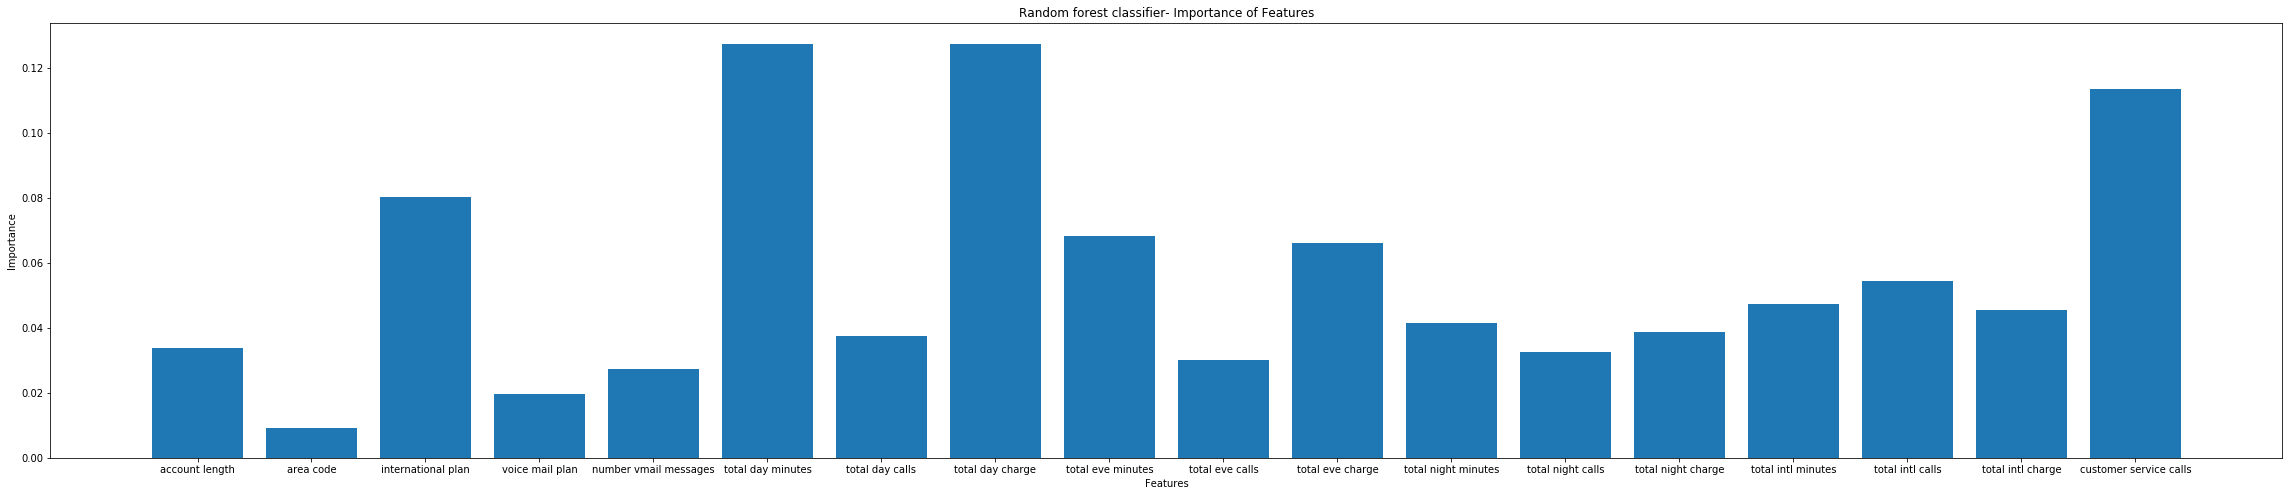

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,8))
plt.bar(xfeat,value)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random forest classifier- Importance of Features')
plt.show()

## USING AUTO-ML

In [12]:
import logging
from azureml.train.automl import AutoMLConfig

In [38]:
project_folder='/Users/deeksharazdan/AzNotebooks/Experiments_Deeksha/churn/Telecom'
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'average_precision_score_weighted',
                             iteration_timeout_minutes = 60,
                             iterations = 25,
                             n_cross_validations = 3,
                             verbosity = logging.INFO,
                             X = x_train, 
                             y = y_train.values.flatten(),
                             path = project_folder)

In [39]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_c219a02d-5458-40ec-8d8c-4fba108e63b2
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION   PIPELINE                                       SAMPLING %  DURATION      METRIC      BEST
         0   StandardScalerWrapper SGD                      100.0000    0:00:12       0.4565    0.4565
         1   StandardScalerWrapper ExtremeRandomTrees       100.0000    0:00:13       0.6351    0.6351
         2   StandardScalerWrapper SGD                      100

In [61]:
# from azureml.widgets import RunDetails
# RunDetails(local_run).show() 

<img width=800 src='screenshot.png'>

In [51]:
# import pandas as pd
# children = list(local_run.get_children())
# metricslist = {}
# for run in children:
#     properties = run.get_properties()
#     metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
#     metricslist[int(properties['iteration'])] = metrics

# rundata = pd.DataFrame(metricslist).sort_index(1)
# rundata

In [54]:
best_run, fitted_model = local_run.get_output()
# print(best_run)
# print(fitted_model)

In [55]:
model=fitted_model

--------------------------------------------------------------------------------------------------------------------

# MODEL_EXPLANATION

--------------------------------------------------------------------------------------------------------------------

This classification (global/local explanation) of interpretation means whether the interpretation method explains a single prediction or the entire model behavior. To comprehend and interpret the whole model at once, we need global interpretability.

Global- How does the model make predictions? How do subsets of the model influence model decisions? Trying to understand feature interactions and importances is always a good step towards understanding global interpretation. 

Of course, visualizing features after more than two or three dimensions becomes quite difficult when trying to analyze interactions. 



In [57]:
import azureml.core
from azureml.core import Workspace, Experiment, Run
from azureml.contrib.explain.model.tabular_explainer import TabularExplainer
from azureml.contrib.explain.model.explanation.explanation_client import ExplanationClient

To address different sophistication levels and needs of the users, the SDK introduces two sets of explainers, Meta Explainers and Direct Explainers.

Direct Explainers are the explainers coming straight from the integrated libraries such as SHAP, LIME, etc.. The MLI SDK wraps all the explainers so they have a common API and output format, but otherwise provides them to users without major changes. Data scientists can invoke a Direct Explainer if they have good knowledge of the explainer and prefer to call it directly, either because they know which one they would like to use or because they would like to evaluate performance of individual explanation methods.

`TabularExplainer`, `TextExplainer` and `ImageExplainer` are the Meta Explainers, which automatically select a suitable direct explainer and generate the best explanation info based on the given model and data sets. `TabularExplainer`, `TextExplainer` and `ImageExplainer` should be called on tabular, text and image datasets respectively.  The Meta Explainers leverage all the libraries (SHAP, LIME, GA2M, Mimic, etc.) that we have integrated or developed.

In [58]:
# Using tabular explainer since this is tabular data
# Provide the trained model you want to explain, the training data, and the list of features 

# For local random forest
#tabular_explainer = TabularExplainer(rf_clf, x_train, features=x_features)

# For autoML model
tabular_explainer = TabularExplainer(rf_clf, x_train, features=x_features)

### Educational Note:
Typically, a feature’s importance is the increase in the model’s prediction error after we permuted the feature’s values. However, frameworks like SHAP, use a combination of feature contributions and game theory to come up with SHAP values. Then, it computes the global feature importance by taking the average of the SHAP value magnitudes across the dataset. 

The permutation feature importance measurement was introduced for Random Forests by Breiman (2001). Based on this idea, Fisher, Rudin, and Dominici (2018) proposed a model-agnostic version of the feature importance — they called it Model Reliance.

### 1. Global explanation

In [59]:
explanation = tabular_explainer.explain_global(x_test)

In [60]:
client.upload_model_explanation(explanation)

When we upload the model explanation to the cloud, you can visualise the explanations by clicking on a particular run.

<img src="viz.png" width=400> 



In [36]:
# When you pass nothing in the paranthesis of this function, it returns all the features 
# already ranked as per its importance, or else you can specify a value to fetch
# top- K important features, and their values

global_importance_values = explanation.get_ranked_global_values()
global_importance_names = explanation.get_ranked_global_names()


In [37]:
# 2. Global values for plotting
for x,v in zip(global_importance_names,global_importance_values):
    d[x].append(v)


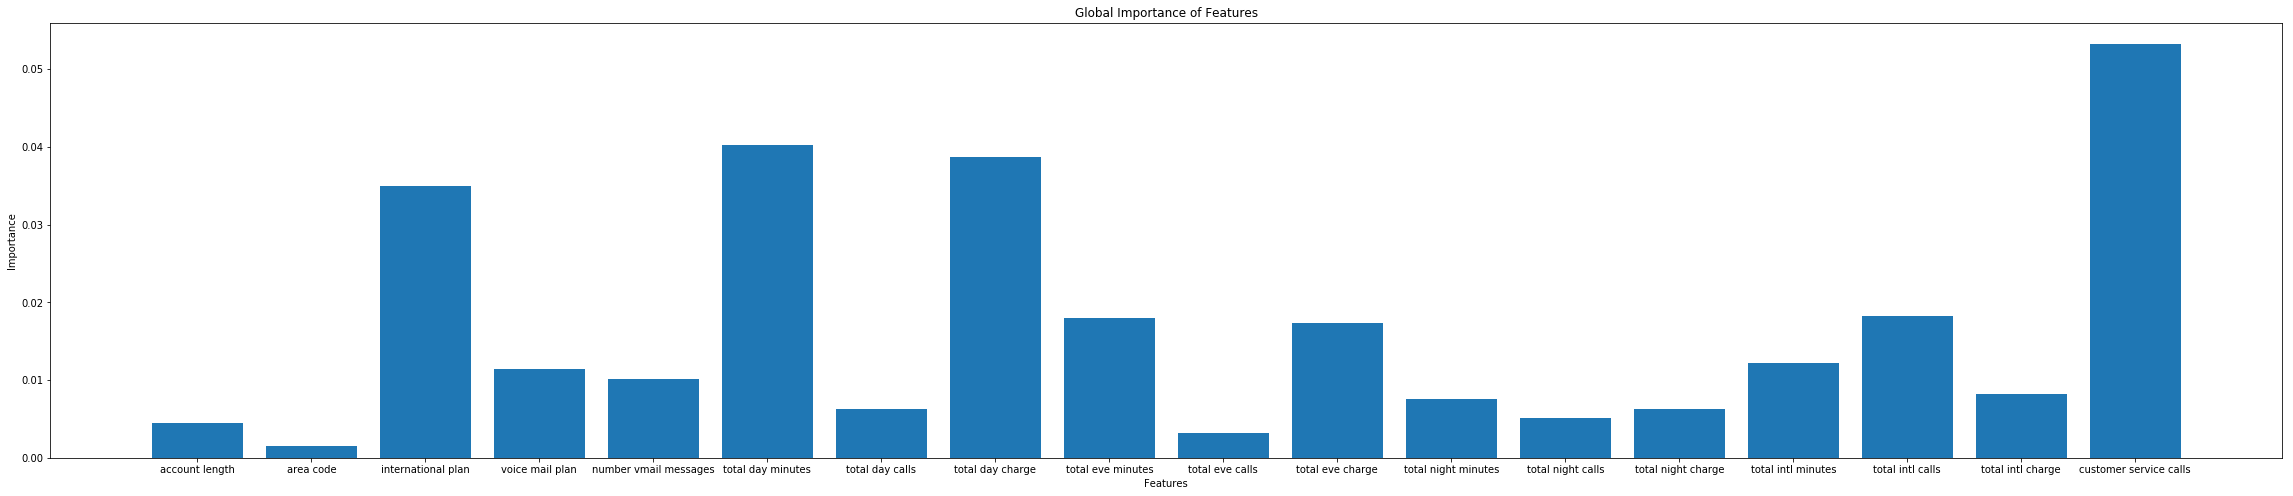

In [38]:
# Global values is the second value to be appended, hence use index [1] to fetch all the global values together

xfeat=[]
value=[]
for x_f,v in d.items():
    xfeat.append(x_f)
    value.append(v[1])


# Plotting the global explanation

import matplotlib.pyplot as plt

plt.figure(figsize=(40,8))
plt.bar(xfeat, value)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Global Importance of Features')
plt.show()

### 2. Explain individual instance predictions (local explanation) 
           
           < Needs to get updated with the new build >

Local- Why did the model make specific decisions for a single instance? and Why did the model make specific decisions for a group of instances? For local interpretability, we do not care about the inherent structure or assumptions of a model and we treat it as a black box. 

For understanding prediction decisions for a single datapoint, we focus specifically on that datapoint and look at a local subregion in our feature space around that point, and try to understand model decisions for that point based on this local region. 

In [39]:
# you can directly get local importance values for all test data by this code

explanation = tabular_explainer.explain_local(x_test)

# local_importance_values = explanation.get_ranked_local_values()
# local_importance_names = explanation.get_ranked_local_names()

In [40]:
# Although, if you like to go one sample at a time, you can use this code-

# since x_test is a df. use - x_test.values[0], else use x_test[0]
local_explanation = tabular_explainer.explain_local(x_test.values[0])

In [41]:
# local feature importance information- Since given <x_test[0,:]> as input, only that sample's local imp is shown.
local_importance_values = local_explanation.local_importance_values

In [42]:
local_importance_values[0],local_importance_values[1]

([0.0033446040983890727,
  0.0037551500913866,
  0.012427571674753907,
  0.010480708123500153,
  0.008789315224514318,
  0.009771729862085963,
  0.007102105919004231,
  0.014170491582230094,
  0.0003799419230988023,
  -0.004311349070516645,
  0.004420241476330904,
  -0.008978956729539949,
  0.0037398422121955274,
  0.004327797082383211,
  0.004801264423895513,
  0.00812365141228501,
  0.006618153452550732,
  0.03262439024435594],
 [-0.0033446040983891247,
  -0.003755150091386641,
  -0.012427571674754025,
  -0.010480708123500139,
  -0.008789315224514416,
  -0.009771729862085908,
  -0.007102105919004247,
  -0.014170491582230039,
  -0.00037994192309884976,
  0.004311349070516637,
  -0.0044202414763309,
  0.008978956729539935,
  -0.0037398422121955313,
  -0.004327797082383241,
  -0.004801264423895516,
  -0.008123651412285014,
  -0.006618153452550721,
  -0.03262439024435597])

In [43]:
# 2. Local values 
for x,v in zip(x_features,local_importance_values[1]):
    d[x].append(v)

xfeat=[]
value=[]
for x_f,v in d.items():
    xfeat.append(x_f)
    value.append(v[2])

In [44]:
xfeat

['account length',
 'area code',
 'international plan',
 'voice mail plan',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls']

In [45]:
value

[-0.0033446040983891247,
 -0.003755150091386641,
 -0.012427571674754025,
 -0.010480708123500139,
 -0.008789315224514416,
 -0.009771729862085908,
 -0.007102105919004247,
 -0.014170491582230039,
 -0.00037994192309884976,
 0.004311349070516637,
 -0.0044202414763309,
 0.008978956729539935,
 -0.0037398422121955313,
 -0.004327797082383241,
 -0.004801264423895516,
 -0.008123651412285014,
 -0.006618153452550721,
 -0.03262439024435597]

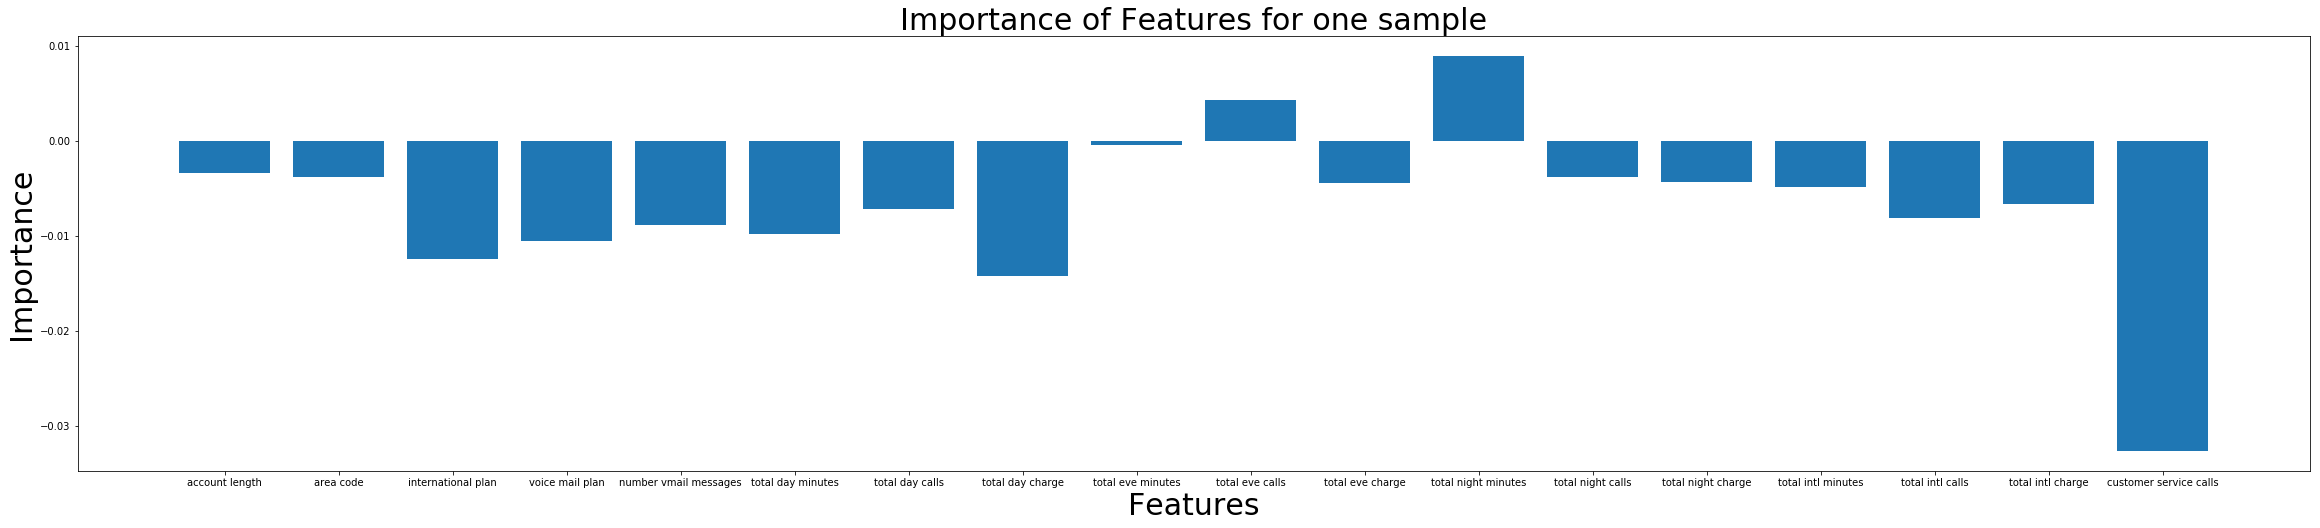

In [49]:
plt.figure(figsize=(40,8))
plt.bar(xfeat, value)
plt.xlabel('Features',fontsize=30)
plt.ylabel('Importance',fontsize=30)
plt.title('Importance of Features for one sample',fontsize=30)
plt.show()

In [90]:
x_test.head(4)

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
1363,117.0,415.0,0,1,31.0,104.9,115.0,17.83,237.6,125.0,20.20,263.4,104.0,11.85,7.7,6.0,2.08,3.0
1217,80.0,408.0,0,1,31.0,166.4,92.0,28.29,238.3,74.0,20.26,150.7,84.0,6.78,10.7,4.0,2.89,4.0
1973,85.0,510.0,0,1,21.0,283.2,110.0,48.14,239.7,108.0,20.37,149.5,80.0,6.73,6.3,1.0,1.70,5.0
461,115.0,408.0,0,0,0.0,147.9,109.0,25.14,228.4,117.0,19.41,299.7,90.0,13.49,9.6,9.0,2.59,3.0


In [92]:
y_test.head(4)

,churn
1363,0
1217,0
1973,0
461,0


In [96]:
rf_pred_test[0]

0

--------------------------------------------------------------------------------------------------------------------

# Notes

--------------------------------------------------------------------------------------------------------------------

1. Any models that are trained on datasets in Python numpy.array, pandas.DataFrame, iml.datatypes.DenseData or scipy.sparse.csr_matrix format are supported by the MLI SDK.
1. The explanation functions accept both models and pipelines as input. If a model is provided, the model is expected to have implemented the prediction function "predict" or "predict_proba" that confirms to the Scikit convention. 